## Self Challenge 1 - Bounding Box ResNet
This is the most ambitious project yet :)

Objectives:
* Design a Segmentation Convolutional Neural Network



In [1]:
import numpy as np # No words for this package
import pandas as pd # Data Processing
import matplotlib.pyplot as plt # Ploting Results
import cv2 # Image Processing
import math # I don't know why this is not built-in
import random # Neural Nets Love Randomly Organized Stuff :p

# Machine Learning Tools
from torch import tensor
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
from torch import from_numpy
from torch import optim
from torch import tensor
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as opt
import torch

## Loading Fashion MNIST

In [2]:
def get_data_from_each_class(dataset, labels, flt_percent=0.05):
    df = []
    for x in range(len(labels.keys())):
        flt = dataset.loc[dataset.label == x]
        flt = flt.sample(int(flt_percent*flt.count()[0]))
        try:
            df = df.append(flt)
        except:
            df = flt
    return df

In [3]:
# Load Data
train_data = pd.read_csv('fashion-mnist_train.csv')
test_data = pd.read_csv('fashion-mnist_test.csv')

#Labels 
labels = {0 : "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
          5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot"}
#Reverse Labels 
reverse_labels = {"T-shirt/top":0 , "Trouser":1 , "Pullover":2 , "Dress":3 , "Coat":4 ,
          "Sandal":5 , "Shirt":6 , "Sneaker":7 , "Bag":8 , "Ankle Boot":9 }
#Color Maps
labels_color_map = {0 : [255,0,0], 1: [98,98,98], 2: [0,0,255], 3: [255,255,0], 4: [255,0,255],
          5: [0,255,255], 6: [128,0,128], 7:[98,0,128], 8: [0,128,128], 9:[0,255,0] }

In [4]:
train_data = get_data_from_each_class(train_data, labels, flt_percent=0.05)
test_data = get_data_from_each_class(test_data, labels, flt_percent=0.05)
print("Train Samples",train_data.count()[0])
print("Test Samples",test_data.count()[0])
#Shuffle Data
train_data = train_data.sample(train_data.count()[0])
test_data = test_data.sample(test_data.count()[0])

Train Samples 2700
Test Samples 450


Dataframe To Usable Matrix Data:

In [5]:
import copy
target = np.zeros((28,28))
i,j = np.indices((28,28))

gausian_target = ((27 - abs(13-i)*1.42)*(27 - abs(13-j)*1.42)) / (28*28)
gausian_not_target = (1-gausian_target)/9
no_target_channels = np.zeros([28,28,10])
for x in range(10):
    no_target_channels[:,:,x] = gausian_not_target
    
def convert_to_image_array(data):
    img_data = []
    img_target_data = []
    img_label = []
    # Append the samples to the samples list
    for j, s in enumerate(data.values):
        # First column contain labels, hence index should start from 1
        img = np.array(data.iloc[j, 1:]).reshape(28,28,1)/255
        img_target = copy.deepcopy(no_target_channels)
        label = data.iloc[j, 0]
        img_target[:,:,label] = gausian_target
        img_data.append(img)
        img_label.append(label)
        img_target_data.append(img_target)
    return img_data, img_target_data, img_label

In [6]:
train_images, train_img_target, train_labels = convert_to_image_array(train_data)
test_images, test_img_target, test_labels = convert_to_image_array(test_data)

Creating Test Scenarios

In [7]:
def create_data(images_set, target_set, number_of_images = 100, max_objs_per_image = 10, images_resolution = [256, 256]):
    Q, P = [], []
    for u in range(number_of_images):
        obj_count = random.randint(3,max_objs_per_image)
        image = np.zeros([images_resolution[0], images_resolution[1], 1])
        target_data = np.zeros([images_resolution[0], images_resolution[1], 10])
        for i in range(obj_count):
            x = 28*random.randint(1,images_resolution[0]//28-1)
            y = 28*random.randint(1,images_resolution[1]//28-1)
            img_idx = random.randint(0, len(images_set)-1) 
            X = images_set[img_idx]
            Y = target_set[img_idx]
            target_data[x:x+28,y:y+28,:]
            image[x:x+28,y:y+28,:] = X
            target_data[x:x+28,y:y+28,:] = Y
        image = np.clip(image, 0, 255)
        Q.append(image)
        P.append(target_data)
    return Q, P

In [8]:
X_test, Y_test = create_data(test_images, test_img_target,number_of_images = 5, max_objs_per_image = 10, images_resolution = [256, 256])
X_train, Y_train = create_data(train_images, train_img_target,number_of_images = 100, max_objs_per_image = 4, images_resolution = [128, 128])

Checking Data Integrity

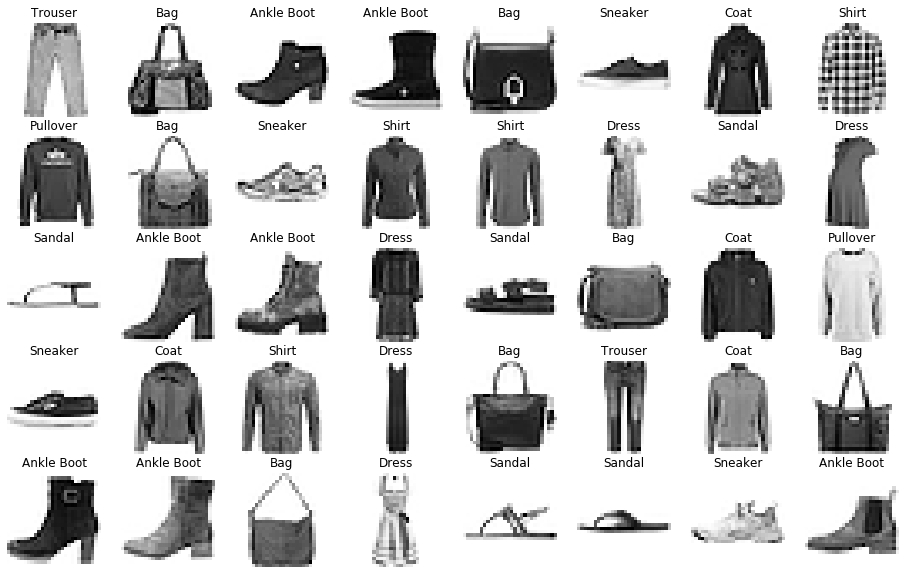

In [9]:
def plot_sample_images(data_sample_images,data_sample_labels,cmap="Blues"):
    f, ax = plt.subplots(5,8, figsize=(16,10))

    for i, img in enumerate(data_sample_images):
        ax[i//8, i%8].imshow(img.reshape(img.shape[0],img.shape[1]), cmap=cmap)
        ax[i//8, i%8].axis('off')
        ax[i//8, i%8].set_title(labels[data_sample_labels[i]])
    plt.show()  
    
plot_sample_images(train_images[:40],train_labels[:40], "Greys")

# Visualization Functions

Here is some visualization of both the training strategy and the expected output!

In [10]:
def plot_input_output_data(image, seg_data, cmap0="Blues", cmap1="Blues"):
    # Plot the sample images now
    plt.imshow(image.reshape(image.shape[0],image.shape[1]), cmap=cmap0)
    plt.axis('off')
    plt.title("Input")
    f, ax = plt.subplots(2,5, figsize=(16,10))
    for i in range(10):
        ax[(i)//5, (i)%5].imshow(seg_data[:,:,i], cmap=cmap1)
        ax[(i)//5, (i)%5].axis('off')
        ax[(i)//5, (i)%5].set_title(labels[i]+" Channel")
        
def prediction_as_colour(image, seg_data_y, size=(5,5),threshold=0.5):
    prediction_color = np.zeros([image.shape[0],image.shape[1],3])
    for x in labels_color_map.keys():
        prediction_color += np.stack((np.where(seg_data_y[:,:,x]>threshold,1,0),)*3, axis=-1)*labels_color_map[x]
    plt.gcf().set_size_inches(size)
    plt.imshow(image.reshape([image.shape[0],image.shape[1]]),cmap="Greys")
    plt.show()
    plt.gcf().set_size_inches(size)
    plt.imshow(prediction_color/255)
    
    legends = []
    import matplotlib.patches as mpatches
    for x in range(10):
        legends.append(mpatches.Patch(color=np.array(labels_color_map[x])/255, label=labels[x]))
    plt.legend(handles=legends, bbox_to_anchor=(1.5,0.5))

def get_boxes(pred,bbsize=(27,27),threshold=0.5):
    bbox = []
    prob = []
    detected_class = []
    x = int(bbsize[1]/2)
    y = int(bbsize[0]/2)
    
    for i in range(pred.shape[1]):
        for j in range(pred.shape[2]):
            arg = np.argmax(pred[:,i,j])
            if((pred[arg,i,j]>threshold) and (i>=y) and (j>=x)):
                prob.append(pred[arg,i,j])
                detected_class.append(arg)
                bbox.append([j-x,i-y,j+x,i+y])
    bbox = np.array(bbox)
    return bbox, detected_class, prob

def non_max_suppression(bbox, clss, prob, threshold=0):
    pick_bbox = []
    pick_class = []
    pick_prob = []
    while len(bbox)>0:

        x1 = bbox[:,0]
        y1 = bbox[:,1]
        x2 = bbox[:,2]
        y2 = bbox[:,3]

        idx = np.argmax(prob)
        pick_bbox.append(bbox[idx])
        pick_class.append(clss[idx])
        pick_prob.append(prob[idx])

        xx1 = np.maximum(x1[idx], x1)
        yy1 = np.maximum(y1[idx], y1)
        xx2 = np.minimum(x2[idx], x2)
        yy2 = np.minimum(y2[idx], y2)

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        area = w*h
        overlap = area/area[idx]
        bbox = np.delete(bbox, np.where(overlap > threshold)[0],axis=0)
        clss = np.delete(clss, np.where(overlap > threshold)[0])
        prob = np.delete(prob, np.where(overlap > threshold)[0])
    
    return pick_bbox, pick_class, pick_prob

def draw_bounding_box_from_model_output(im, output, size=(5,5), threshold=0.9):
    bbox, cls, prob = get_boxes(output,threshold=threshold)
    bbox, cls, prob = non_max_suppression(bbox,cls,prob)
    
    sample = copy.deepcopy(im.reshape(im.shape[0],im.shape[1])*255)
    for i in range(len(bbox)):
        cv2.rectangle(sample, (bbox[i][0], bbox[i][1]), (bbox[i][2], bbox[i][3]), 255)
        pred = str("%.1f"%float(prob[i]*100))
        cv2.putText(sample, labels[cls[i].item()], (bbox[i][0]+1, bbox[i][1]-1), cv2.FONT_HERSHEY_PLAIN, 0.8, 255)
        cv2.putText(sample, pred+"%", (bbox[i][0]-1, bbox[i][3]+10), cv2.FONT_HERSHEY_PLAIN, 0.8, 255)

    plt.gcf().set_size_inches(size)
    plt.grid(False)
    plt.imshow(sample, cmap='Greys')
    return sample, bbox, cls, prob

We basically make a normal distribution around the center of the image using different channels to represent diferent classes

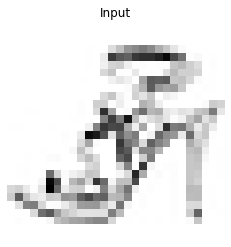

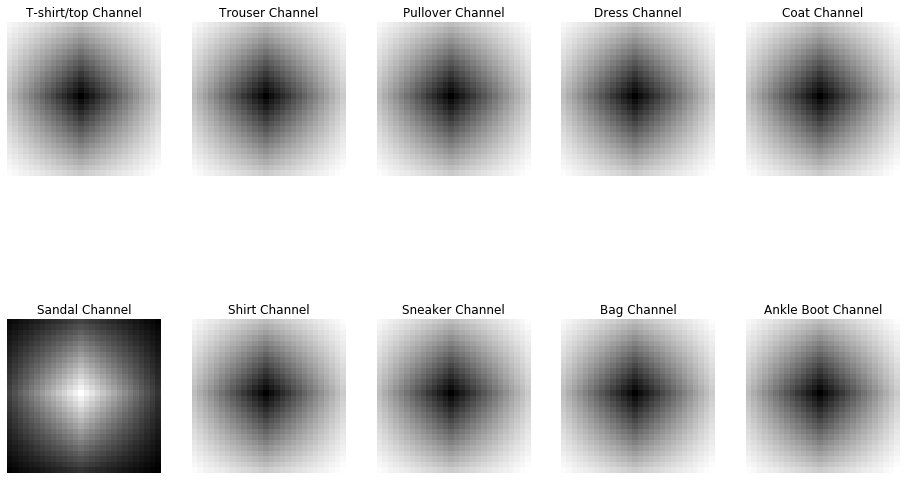

In [11]:
plot_input_output_data(train_images[50], train_img_target[50], "Greys", "gray")

Another representation would be to draw the predictions as diferent colours!

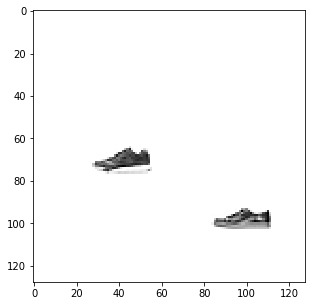

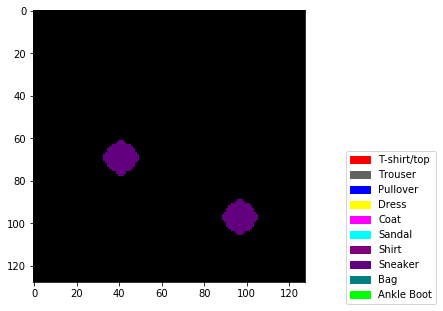

In [12]:
prediction_as_colour(X_train[0], Y_train[0], threshold=0.5 )

Based on the distributions, we can draw bounding boxes around the most probable distribution, *note: these are the test targets*

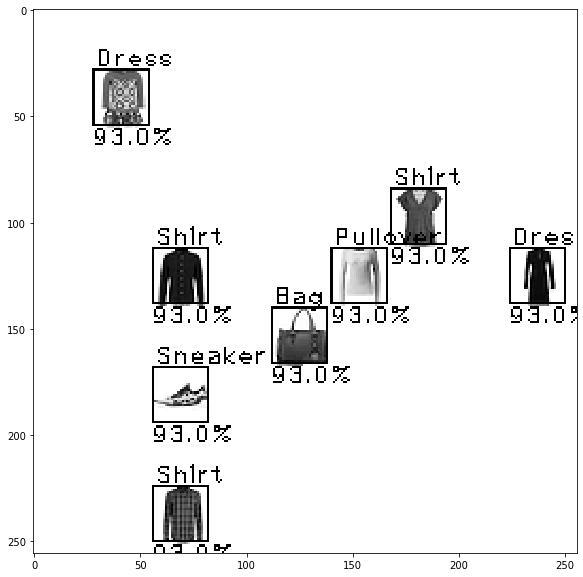

In [13]:
def simulate_model_output(image):
    image = np.transpose(np.array(image), (2,0,1))
    return from_numpy(np.array([image])).float()
sample, bbox, cls, prob = draw_bounding_box_from_model_output(X_test[-1], simulate_model_output(Y_test[-1])[0], size=(10,10))

# Building and Training ResNet!

Here we simply persuade the training to take new shape so torch will like it!

In [14]:
def tensor2image(tensor):
    return np.transpose(tensor.numpy(), (1,2,0))

def tensor_batch2image_batch(tensor):
    return np.transpose(tensor.numpy(), (0,2,3,1))

def image2tensor(image):
    image = np.transpose(np.array(image), (2,0,1))
    return from_numpy(np.array(image)).float()

def image_batch2tensor(image_batch):
    batch = np.transpose(np.array(image_batch), (0,3,1,2))
    return from_numpy(np.array(batch)).float()

class imageDatasetBuilder(Dataset):
    def __init__(self, images_in, images_out, limit_dataset_size=None, transform=None):
        self.images_in = images_in
        self.images_out = images_out
        self.x, self.y = [], []
        for x in range(len(self.images_in)):
            self.x.append(image2tensor(self.images_in[x]))
            self.y.append(image2tensor(self.images_out[x]))
        self.x = self.x
        self.y = self.y
    def __len__(self):
        return len(self.x)

    def __getitem__(self,idx):
        return self.x[idx], self.y[idx]

In [15]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)
print(X_train.shape)
print(Y_train.shape)

(100, 128, 128, 1)
(100, 128, 128, 10)


Here is the DataLoader so that the GPU does not run out of memory. 

In [16]:
batch_size = 50

db = imageDatasetBuilder(X_train, Y_train)
print(len(db))
data_loader = DataLoader(db, batch_size=batch_size)

x, y = next(iter(data_loader))
print(x.shape)
print(y.shape)

100
torch.Size([50, 1, 128, 128])
torch.Size([50, 10, 128, 128])


Here is the Archtecture of our Convolutional Neural Network:

In [17]:
def create_conv(n_feat, kernel_size, bias=True):
    return nn.Conv2d(
        n_feat, n_feat, kernel_size,
        padding=(kernel_size // 2), bias=bias)


class ResBlock(nn.Module):
    def __init__(
        self, n_feat, kernel_size,
        bias=True, bn=False, act=nn.ReLU(True), res_scale=1):


        super(ResBlock, self).__init__()
        modules_body = []
        for i in range(2):
            modules_body.append(create_conv(n_feat, kernel_size, bias))
            if bn: modules_body.append(nn.BatchNorm2d(n_feat))
            if i == 0: modules_body.append(act)

        self.body = nn.Sequential(*modules_body)
        self.res_scale = res_scale

    def forward(self, x):
        res = self.body(x).mul(self.res_scale)
        res += x

        return res

class Model(nn.Module):
    def __init__(self, n_features ,n_resblocks, in_channels=1, out_channels=10):
        super(Model, self).__init__()
        self.start = nn.Conv2d(in_channels, n_features, 3, padding=1, bias=True)
        resblocks = []
        for i in range(n_resblocks):
            resblocks.append(ResBlock(n_features, 3, res_scale=0.15))
    
        resblocks.append(nn.Conv2d(n_features, n_features, 3, padding=1, bias=True))
        self.resblocks = nn.Sequential(*resblocks)
        self.end = nn.Conv2d(n_features, out_channels, 3, padding=1, bias=True)
        self.act_end = nn.Softmax2d()
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                m.bias.data.zero_()

            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
                
    def forward(self, x):
        xs = self.start(x)
        x = self.resblocks(xs)
        x = self.end(x)
        x = self.act_end(x)
        return x

In [18]:
load_model = False
load_from_path = "fmnist_bbResNet_2000.ptp"
train_model = True

In [19]:
model = Model(128,4).cuda()
if load_model:
    model.load_state_dict(torch.load(load_from_path))

dummy_input = torch.ones((1,1,256,256)).cuda().float()
print('Model Input Shape:',dummy_input.shape)
print('Model Output Shape:',model(dummy_input).shape)
print(model)

Model Input Shape: torch.Size([1, 1, 256, 256])
Model Output Shape: torch.Size([1, 10, 256, 256])
Model(
  (start): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (resblocks): Sequential(
    (0): ResBlock(
      (body): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (1): ResBlock(
      (body): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (2): ResBlock(
      (body): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (3): ResBlock(
      (body):

# Training
Our GPU seams lazy, let us put it to work..

In [20]:
# Train
def train(data_loader, model,
          num_epochs = 5000,
          epoch_interval_save_sample = 1000,
          learning_rate_a = 1e-3,
          learning_rate_b = 1e-4,
          cut_learning_rate = 0.009):
    criterion = nn.MSELoss()
    optimizer = opt.Adamax(
        model.parameters(), lr=learning_rate_a, weight_decay=1e-6)
    imgs = []
    losses = []

    using_LR = 'A'
    rand = db[random.randint(0,len(db))]
    for epoch in range(num_epochs):
        for data in data_loader:
            x_, y_ = data
            optimizer.zero_grad()
            x = Variable(x_).cuda()
            y = Variable(y_).cuda()
            # ===================forward=====================
            output = model(x)
            loss = criterion(output, y)
            # ===================backward====================
            loss.backward()
            optimizer.step()
        # ===================log========================
        losses.append(loss.data.item())
        if (loss.data.item() <= cut_learning_rate):
            using_LR = 'B'
            for param_group in optimizer.param_groups:
                param_group['lr'] = learning_rate_b
        else:
            using_LR = 'A'
            for param_group in optimizer.param_groups:
                param_group['lr'] = learning_rate_a

        print('Using LR_'+using_LR+' epoch [{}/{}], loss:{:.8f}'
              .format(epoch+1, num_epochs, loss.data.item()), end='\r')
        if ((epoch+1) % epoch_interval_save_sample == 0):
            x = Variable(rand[0]).cuda()
            output = model(x.unsqueeze_(0))
            imgs.append([(rand[0],rand[1]),output.cpu().data])
            torch.save(model.state_dict(), "fmnist_bbResNet_"+str(epoch+1)+".ptp")
            #save_image(pic, './dc_img/image_{}.png'.format(epoch))
    return imgs, losses

In [21]:
num_epochs = 1000
epoch_interval_save_sample = 500
if(train_model): 
    imgs, losses = train(data_loader, model,
                         num_epochs = num_epochs,
                         epoch_interval_save_sample = epoch_interval_save_sample,
                         learning_rate_a = 1e-4,
                         learning_rate_b = 1e-6,
                         cut_learning_rate = 0.009)


Assessing the training process:

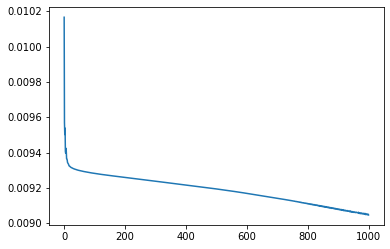

In [29]:
if(train_model):
    x = [x for x in range(len(losses))]
    plt.plot(x, losses)

What did ResNet Learn? 

epoch 500


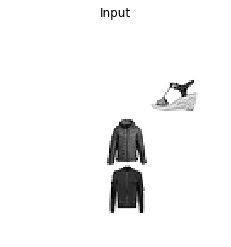

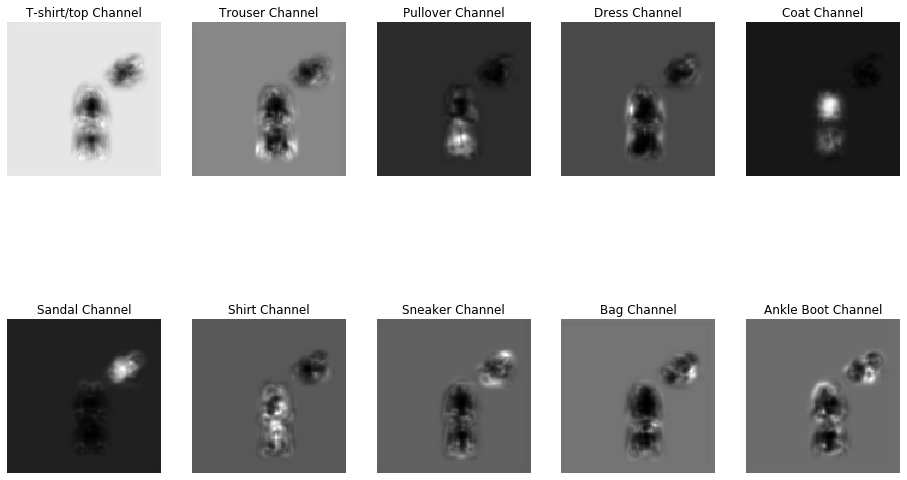

epoch 1000


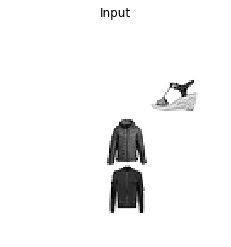

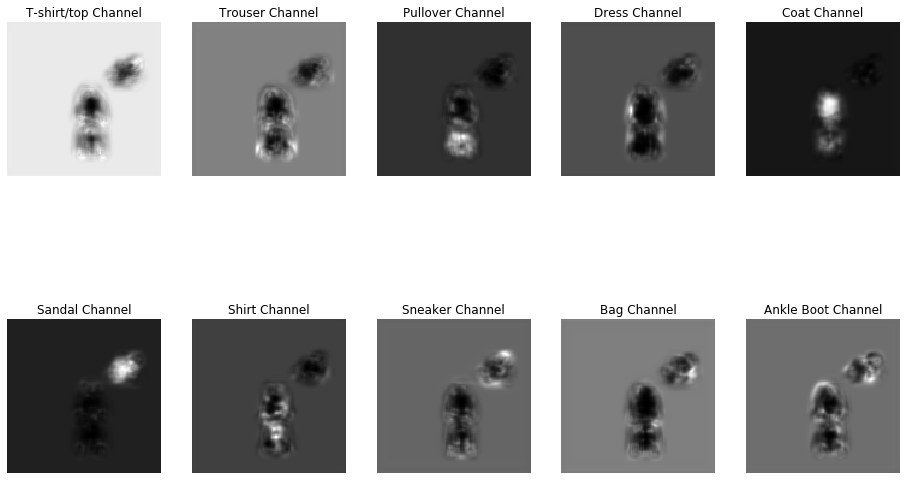

In [30]:
if(train_model):
    for i in range(len(imgs)):
        print("epoch",(i+1)*epoch_interval_save_sample)
        x = tensor2image(imgs[i][0][0])
        y = tensor2image(imgs[i][1][0])
        Y = tensor2image(imgs[i][0][1])
        plot_input_output_data(x, y, "Greys", "gray")
        plt.show()

# Testing

As defined earlier, let us push some data through the network and watch the results

In [31]:
def push_batch_model(im_bach, model, is_normalized=False):
    with(torch.no_grad()):
        im_t = image_batch2tensor(im_bach)
        X1 = Variable(im_t).cuda()
        output = model(X1).cpu().data
        return output

output = push_batch_model(X_test[:100], model)

Hmmm ok.. how about those bounding boxes?

In [32]:
output.max()

tensor(0.9396)

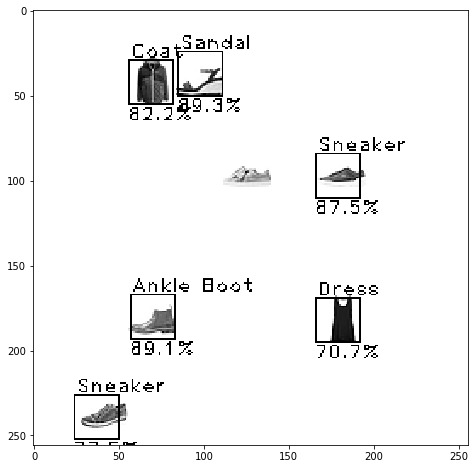

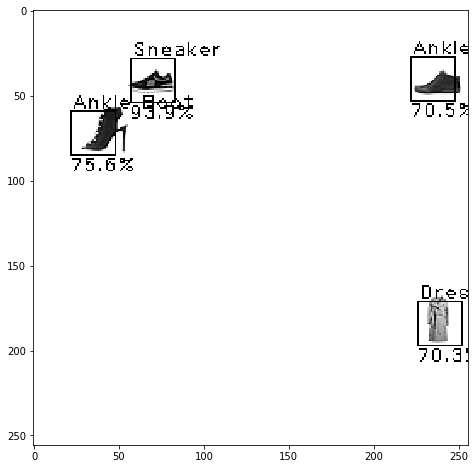

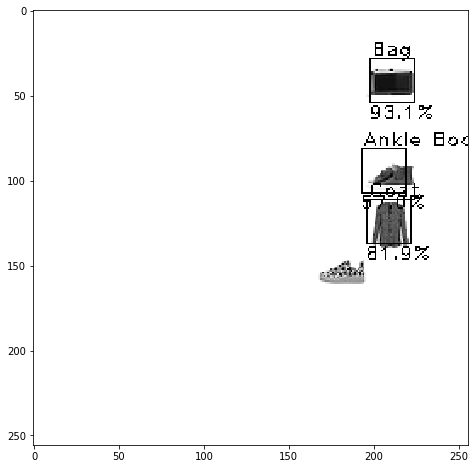

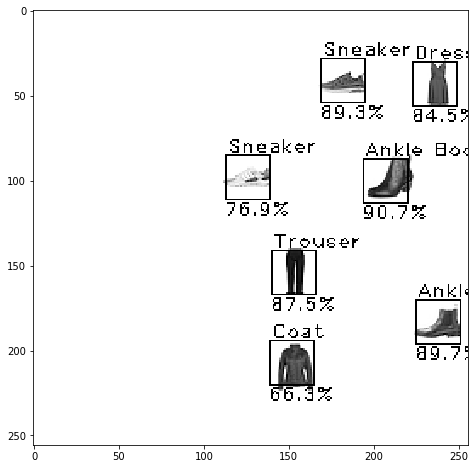

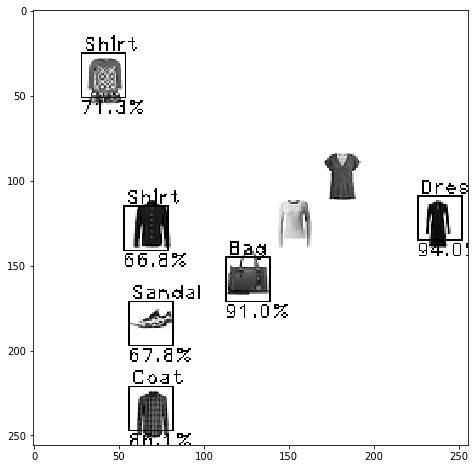

In [33]:
for x in range(5):
    _im, _bbox, _classes, _probs = draw_bounding_box_from_model_output(
        X_test[:100][x], output[x], size=(8,8), threshold=0.5)
    plt.show()

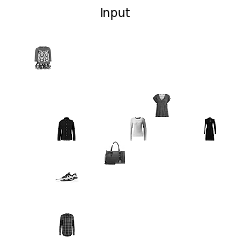

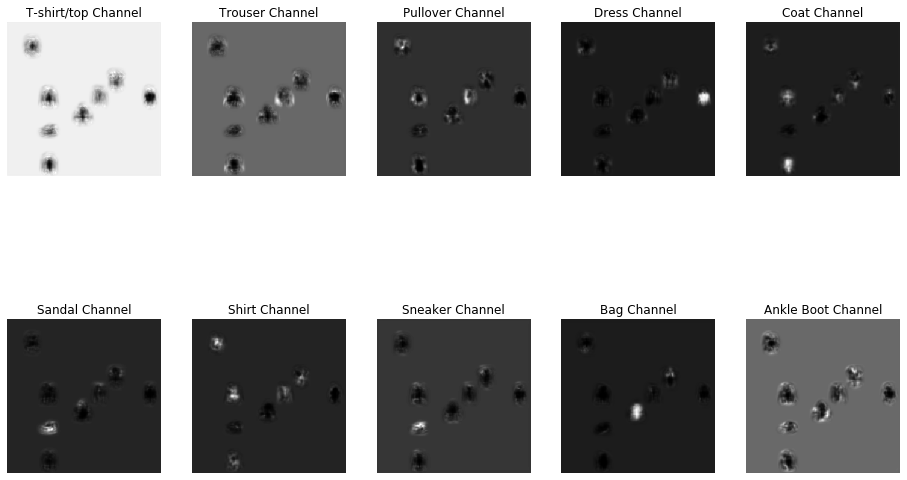

In [40]:
plot_input_output_data(
    X_test[:100][-1], tensor_batch2image_batch(output)[-1], cmap0="Greys", cmap1="gray")
plt.show()